# Importando librerías y funciones

In [1]:
#Librería de graficación
import matplotlib.pyplot as plt
import matplotlib as mp
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gsa
import matplotlib.ticker as mticker
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot, transforms



#Librerías de procesamiento matemático y lectura de archivos
import numpy as np
import netCDF4 as nc
import pandas as pd
import glob
import os
from scipy import signal

#Librería de estadística
import scipy as sp
from scipy.stats import pearsonr,spearmanr

#librería para manejo de fechas
from datetime import datetime,timedelta

plt.style.use("seaborn")
mp.rcParams['xtick.labelsize']=15
mp.rcParams['ytick.labelsize']=15

mp.rcParams['axes.labelsize']=17

In [2]:
def reading_netcdf(ruta):
    data=nc.Dataset(ruta)
    for i in data.variables:
        try:
            print (i,data.variables[i].shape,data.variables[i].units) 
        except:
            print (i,data.variables[i].shape) 
    print("\n")
    data_variables=[np.array(data[i][:]) for i in list(data.variables.keys())]
    return data_variables

Función para obtener realizar un análisis espectral

In [3]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1/len(serie))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

# Cargando los datos

In [4]:
rutas_mon = np.sort(glob.glob("/home/franklin/Documentos/GitHub/TDG/Dataset/Monthly/*.nc"))
[lat_mon,sla_mon,time_mon,lon_mon]=reading_netcdf(rutas_mon[0])

latitude (45,) degrees_north
ssh (276, 45, 185) m
time (276,) hours since 1950-01-01
longitude (185,) degrees_east




In [5]:
rutas = np.array(np.sort(glob.glob("/home/franklin/Documentos/GitHub/TDG/Dataset/CMEMS_ECMFW/*.nc")),dtype="str")

#Al estar por años se debe concatenar
for i in range(0,len(rutas)):
    if i==0:
        [adt,time,lat,lon,ugos,vgos,vgosa,sla,ugosa]=reading_netcdf(rutas[i])
    else:
        [adt,time2,lat,lon,ugos,vgos,vgosa,sla2,ugosa]=reading_netcdf(rutas[i])
        sla=np.concatenate((sla,sla2))
        time=np.concatenate((time,time2))

adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (366, 45, 185) m
time (366,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (366, 45, 185) m/s
vgos (366, 45, 185) m/s
vgosa (366, 45, 185) m/s
sla (366, 45, 185) m
ugosa (366, 45, 185) m/s


adt (367, 45, 185) m
time (367,) days since 1950-01-01 00:00:00
latitude (45,) degrees_north
longitude (185,) degrees_east
ugos (367, 45, 185) m/s
vgos (367, 45, 185) m/s
vgosa (367, 45, 185) m/s
sla (367, 45, 185) m
ugosa (367, 45, 185) m/s


adt (366, 45, 185) m
tim

# Con datos mensuales

## Definiendo la serie temporal

A continuación se preparan las series de datos espacio-temporales a usar y se determina la serie temporal final que será evaluada a través de el análisis espectral

In [6]:
# lat_max = 4.5
# lat_min = 3.5
# lon_max = -92
# lon_min = -94

# ind_lat = np.where((lat<=lat_max) & (lat>=lat_min))[0]
# ind_lon = np.where((lon<=lon_max) & (lon>=lon_min))[0]

La serie temporal que se determinará para la región del océano pacífico colombiano será el promedio longitudinal y latitudinal de los datos obtenidos

In [7]:
sla_mon[sla_mon<=-1000]=np.nan
# da=[datetime(1950,1,1,0,0,0)+timedelta(days=int(time[w])) for w in range (0,len(time))]
da=[datetime(1950,1,1,0,0,0)+timedelta(hours=int(time_mon[w])) for w in range (0,len(time_mon))]
date=pd.DatetimeIndex(da)
new_array = np.array(date.to_pydatetime(), dtype=object)
sla_copy_mon=np.copy(sla_mon)

In [8]:
# sla_lat=np.nanmean(sla_mon[:,ind_lat],axis=1)
# serie_temp=np.nanmean(sla_lat[:,ind_lon],axis=1)

In [9]:
serie_mon=np.nanmean(sla_copy_mon,axis=1)
serie_temp_mon=np.nanmean(serie_mon,axis=1)

serie_sla_mon=pd.Series(serie_temp_mon,date)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'sla [m]')

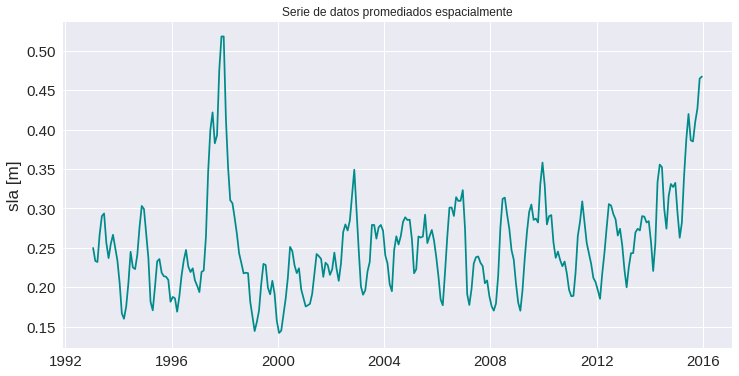

In [10]:
plt.figure(figsize=(12,6))
plt.title("Serie de datos promediados espacialmente")
plt.plot(serie_sla_mon,c="darkcyan")
plt.ylabel("sla [m]")
# plt.savefig(".\Graficas\Series.jpg",dpi=800,box_inches="tight",pad_inches=0)

## Realizando el análisis espectral

In [11]:
sla_fourier,sla_freq_pos,sla_potencias,sla_periodos,sla_freq,=T_fourier(serie_sla_mon.values)

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


## Graficando el espectro de potencias

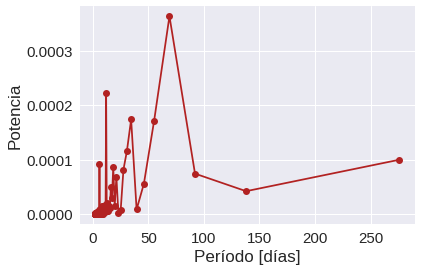

In [12]:
# %matplotlib notebook
plt.figure()
plt.plot(sla_periodos[sla_freq_pos],sla_potencias[sla_freq_pos],'-o',c="firebrick")
# plt.xscale("log")
plt.xlabel("Período [días]")
plt.ylabel("Potencia")
plt.savefig(".\Graficas\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

## Seleccionando la banda de interés

Puede notarse que el intervalo de períodos que más regula la variable de nivel medio del mar está comprendido entre ... y ... días.

In [13]:
freq_fil=np.copy(sla_fourier)
# freq_fil[np.where(np.abs(1/sla_freq)<365)]=0
freq_fil[np.where(np.abs(1/sla_freq)<12)]=0

Pot_fil=np.abs(freq_fil*1/len(freq_fil))**2

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


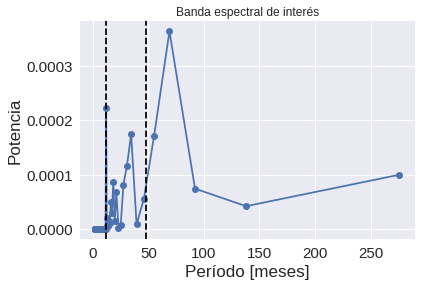

In [14]:
plt.figure()
plt.title("Banda espectral de interés")
plt.plot(sla_periodos[sla_freq_pos],Pot_fil[sla_freq_pos],'-o')
# plt.xscale("log")
plt.xlabel("Período [meses]")
plt.ylabel("Potencia")
plt.axvline(12,0,1,ls='--',c="k")
plt.axvline(12*4,0,1,ls='--',c="k")
# plt.axvline(365,0,1,ls='--',c="k")
# plt.axvline(365*4,0,1,ls='--',c="k")
# plt.xlim(0,24)
plt.savefig(".\Graficas\Banda espectral interes.jpg",dpi=800,box_inches="tight",pad_inches=0)

## Mapas de varianza

In [17]:
# sla_var=sum(Pot_fil)
pearson_mon=np.zeros((len(lat),len(lon)))
spearman_mon=np.zeros((len(lat),len(lon)))
var_mon=np.zeros((len(lat),len(lon)))
var_banda_mon=np.zeros((len(lat),len(lon)))
var_porcentaje_mon=np.zeros((len(lat),len(lon)))
# matriz_inversa=np.zeros((len(time)),len(lat),len(lon))

for i in range(len(lat)):
    for j in range(len(lon)):
        point=sla_copy_mon[:,i,j]
        d=np.where(np.isnan(point)==True)[0]
        if len(d)==0:
            tf_p,fp_p,pot_p,per_p,f_p=T_fourier(point)
#             pos_banda=np.where((np.abs(per_p)>365) & (np.abs(per_p)<365*3))[0]
            pos_banda=np.where((np.abs(per_p)>12) & (np.abs(per_p)<36))[0]
            var_banda_mon[i,j]=sum(pot_p[pos_banda])
            var_mon[i,j]=np.var(point)
            var_porcentaje_mon[i,j]=((var_banda_mon[i,j])/np.var(point))*100

            pearson_mon[i,j]=pearsonr(serie_sla_mon.values,point)[0]
            spearman_mon[i,j]=spearmanr(serie_sla_mon.values,point)[0]
        else:
            var_banda_mon[i,j]=np.NaN
            var_mon[i,j]=np.NaN
            var_porcentaje_mon[i,j]=np.NaN
            pearson_mon[i,j]=np.NaN
            spearman_mon[i,j]=np.NaN

/home/franklin/my_projects_dir/entorno_jup/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


## Varianza para cada píxel

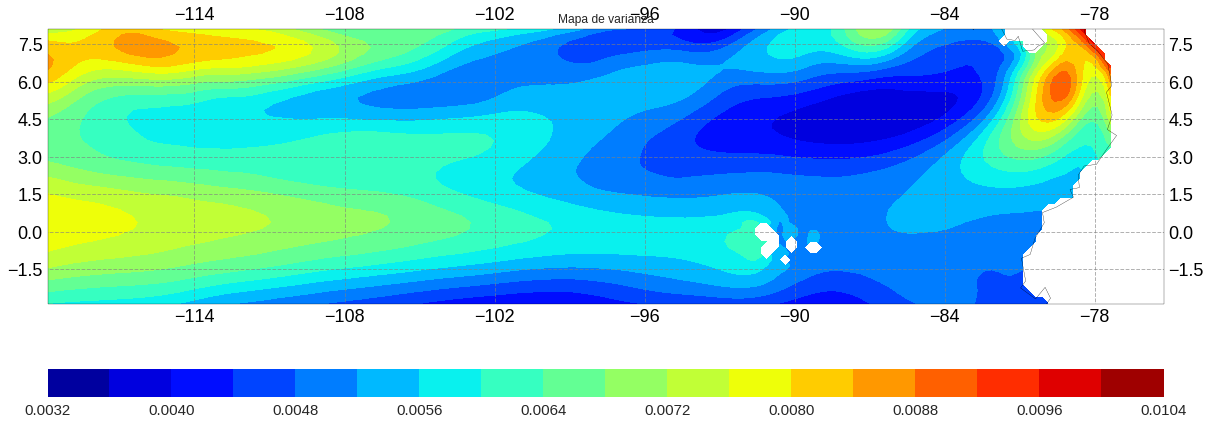

In [18]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title("Mapa de varianza")
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## Varianza en la banda

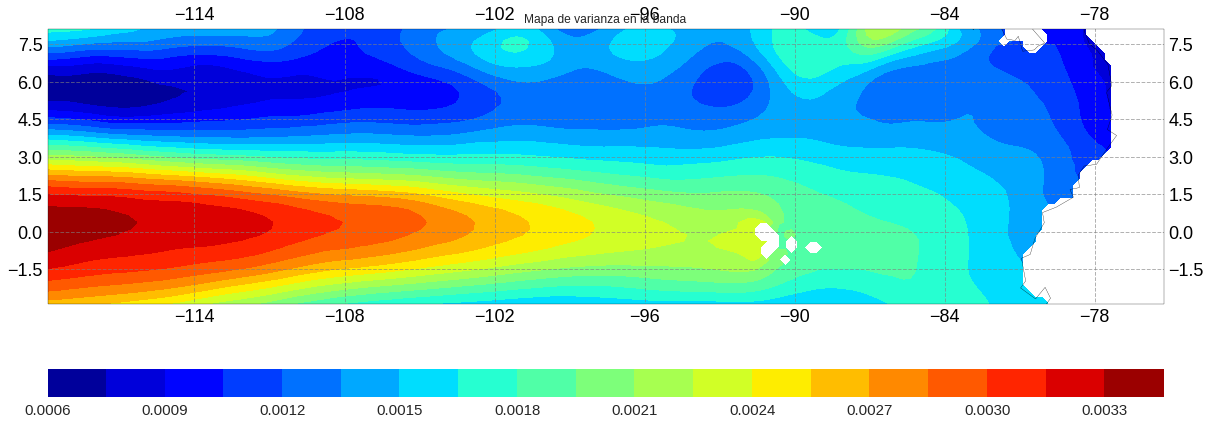

In [19]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title("Mapa de varianza en la banda")
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_banda_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## Porcentaje de varianza

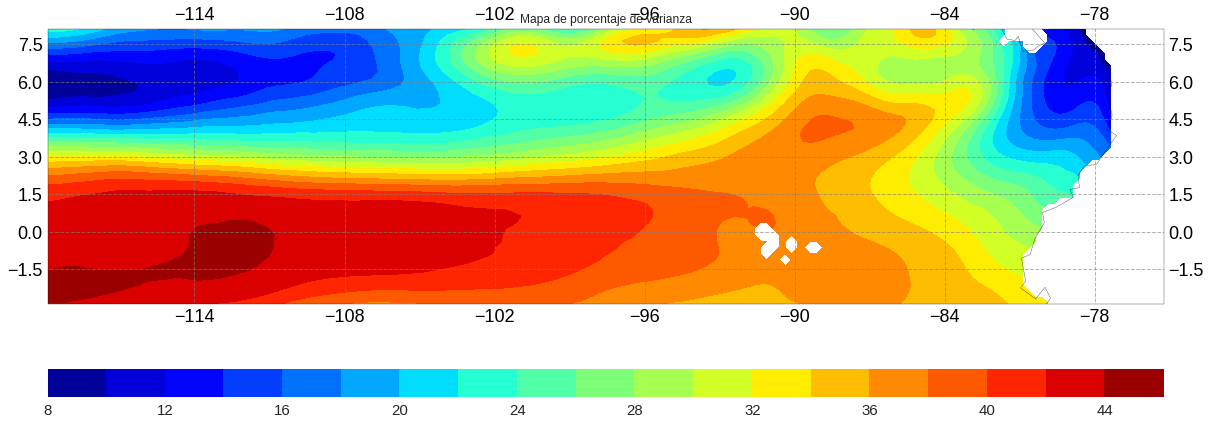

In [20]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title("Mapa de porcentaje de varianza")
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,var_porcentaje_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

## Correlación de Pearson y Spearman

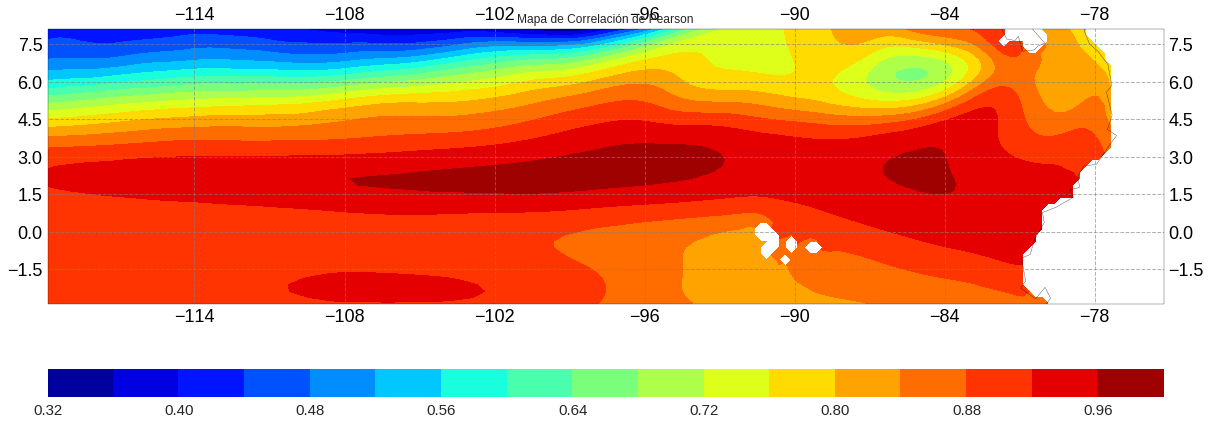

In [21]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title("Mapa de Correlación de Pearson")
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,pearson_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

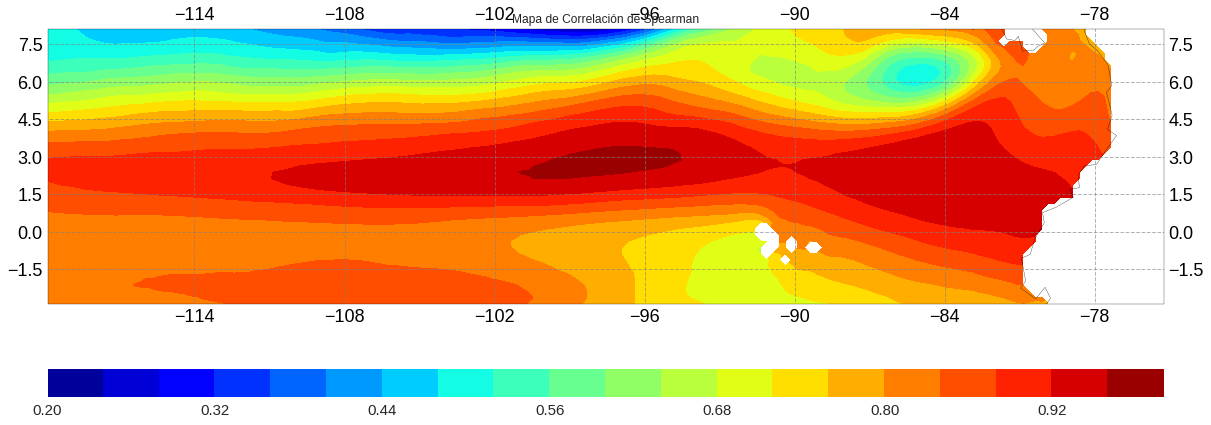

In [22]:
fig=plt.figure(figsize=(20,20))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
ax.set_title("Mapa de Correlación de Spearman")
x,y=np.meshgrid(lon,lat)
cf=ax.contourf(x,y,spearman_mon,20,transform=ccrs.PlateCarree(),cmap="jet")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.6, linestyle='--')
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
ax.coastlines()
cbar=plt.colorbar(cf,orientation="horizontal",fraction=0.1, pad=0.06,aspect=40)
cbar.ax.tick_params(labelsize=15) 

plt.show()

# Preguntas importantes

Tenemos dos preguntas de análisis:

\begin{enumerate}
    \item ¿Cuál es el efecto del ENSO en la variabilidad interanual del nivel del mar?
    \item Durante una fase cálida ¿existe una zona mar afuera que pueda servir para pronosticar el nivel del mar en regiones más costeras?
\end{enumerate}    

**1. Teniendo en cuenta que un objetivo es evaluar el efecto del ENSO en el nivel del mar**

Cómo evaluar dicho efecto más allá de:

1. realizar la EOF que permite conocer la estructura espacial y los modos de oscilación.
2. realizar gráficas de porcentajes de varianza

**2. Respecto al segundo gran objetivo hay muchas dudas sobre**

Sin predeterminar la zona:
- ¿Cómo identificar una zona que tenga un comportamiento similar a la costa?
- ¿Cómo saber si dicha zona tiene el comportamiento rezagado? (esto con el objetivo de que sirva como pronóstico de llegadas de ENSO)

Ya se ha hecho:

1. Se han hecho mapas de correlación (inclusive con rezagos), pero eso puede sesgar los resultados
2. Se han graficados diagramas de Hovmöller para identificar situaciones espaciales

¿Aquí actuaría la EOF?, ¿Sería útil una EOF extendida?

**3. Preguntas de cóctel**

- ¿Porqué la EOF varía de una resolución temporal a la otra? (Se entiende que en términos del porcentajes de varianza las cosas pueden cambiar)

- ¿Suavizado o filtrado con Fourier para ENSO?

- Sí uso Fourier para estudiar ENSO, ¿entre que años filtro?